Please follow these instructions prior to running code: 
- Insert "pip install pyreadr" in terminal (to read r data format to python)
- Insert "pip install seaborn" in terminal (for linear trend analysis)

# Assessing the Effects of Participant Activity and Environmental Parameters on PM$_2$$_.$$_5$ Exposure in the Bono East Region, Ghana

## Introduction & Motivation

Household air pollution (HAP) from the burning of solid fuels (e.g., wood, crop residues, dung, coal) indoors is associated with 3.8 million deaths annually. Worldwide, around 2.8 billion people are exposed to high levels of cooking-related HAP. Airborne fine particulate matter ≤ 2.5 μm (PM₂.₅) is an established environmental health risk factor to measure the toxicity of HAP. PM₂.₅ is hazardous because it is small enough to deposit deep in the lungs. Participants wore a personal monitoring device, Ultrasonic Personal Air Sampler (UPAS), to detect PM₂.₅ exposure. The UPAS also detects different parameters (e.g., temperature, relative humidity, wearing compiance).

Various factors can affect PM₂.₅ exposure, notably the Harmattan and non-Harmattan season in Sub-Saharan Africa. The Harmattan season usually occurs between the end of November and mid-March. Over Harmattan season, dry dusty northeasterly trade winds blow from the Sahara Desert over West African to the Atlantic Ocean. 

## Datasets

I will UPAS datasets collected from June 2021 to March 2023 deployed in 35 communities in the Bono East Region, Ghana. The information I will use from a UPAS dataset includes PM₂.₅ exposure (µg/m³), temperature (ºC), relative humidity (%), and wearing compliance (hours). The active pumping interval is 48 hours with data collected every 30 seconds during the day and every 15 minutes at night (10pm-4am). Some of this data was converted to a .rds file, so I used pyreadr package in python to make the file readable in python. I converted these datasets and csv datasets to pandas DataFrame to conduct my analysis.

## Planned Analysis

I conduct 3 main analyses to answer my scientific question. First, I conduct time-series analysis of PM₂.₅ exposure across the entire duration of the study (June 2021 to March 2023) to detect temporal patterns of PM₂.₅ exposure. This temporal pattern will allow me to assess if the PM₂.₅ exposure increased or decreased during the Harmattan season. Additionally, time-series analysis of daily P M₂.₅ exposure will allow me to examine activities that increase PM₂.₅ exposure (e.g., cooking). Second, I will use k-means clustering if I discover a temporal trend in PM₂.₅ exposure to seperate the PM₂.₅ exposures into different groups (e.g., Harmattan vs. non-Harmattan season). Finally, I will use linear trend analysis to determine if temperature, relative humidity, and wearing compliance impact PM₂.₅ exposure.

## Objectives & Hypothesis

In this project, I will determine which parameters affect PM₂.₅ exposure. I will explore how different parameters, including wearing compliance, temperature, relative humidity, and dust-loading from the Harmattan season affect the distribution of PM₂.₅ exposure. To conduct my analysis, I will use PM₂.₅ exposures, temperature, relative humidity, and compliance hours collected form UPAS's from June 2021 to 2023. The UPAS collected data every 30 seconds during the day and every 15 minutes at night. 

I hypothesize that temperature, relative humidity, Harmattan vs. non-Harmattan, and wearing compliance will all affect PM₂.₅ exposures. The Harmattan season is categorized as arid (lower relative humidity), dusty, and lower temperatures, which increases dust loading. The non-Harmattan season is categorized as more humid (higher relative humidity), less dusty, and higher temperatures, which decreases dust loading. I hypothesize that increased dust loading leads to higher PM₂.₅ exposure and decreased dust loading leads to lower PM₂.₅ exposure.

In [4]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For mapping
import warnings
from cartopy import crs as ccrs, feature as cfeature

# For k-means clustering
from scipy.cluster.vq import kmeans,vq
import matplotlib.cm as cm
import matplotlib as mpl

# For linear trend analysis
import seaborn as sns
import scipy.stats as stats

In [5]:
# Read data
realtimepm25_compliance = pyreadr.read_r('~/rces-assignments/Final_Project/upas1436_realtimepm25_compliance.rds')
df_compliance = realtimepm25_compliance[None] #creates pandas dataframe

df_KHU_FB_corr_filter_mass = pd.read_csv('~/rces-assignments/Final_Project/20230616_KHU_FB_corr_filter_mass.csv')

df_summarized_compliance = pd.read_csv('~/rces-assignments/Final_Project/summarizedupas1436_compliance_r3_.csv')

df_rh_temp = pyreadr.read_r('~/rces-assignments/Final_Project/upas1436_community_112124.rds')
df_rh_temp_compliance = df_rh_temp[None]

gcratio = pd.read_csv("~/rces-assignments/Final_Project/upas_gcratio.csv")


In [6]:
# Drop NaN values from datasets

df_compliance = df_compliance.dropna()
df_KHU_FB_corr_filter_mass = df_KHU_FB_corr_filter_mass.dropna()
df_summarized_compliance = df_summarized_compliance.dropna()
df_rh_temp_compliance = df_rh_temp_compliance.dropna()
gcratio = gcratio.dropna()

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" c

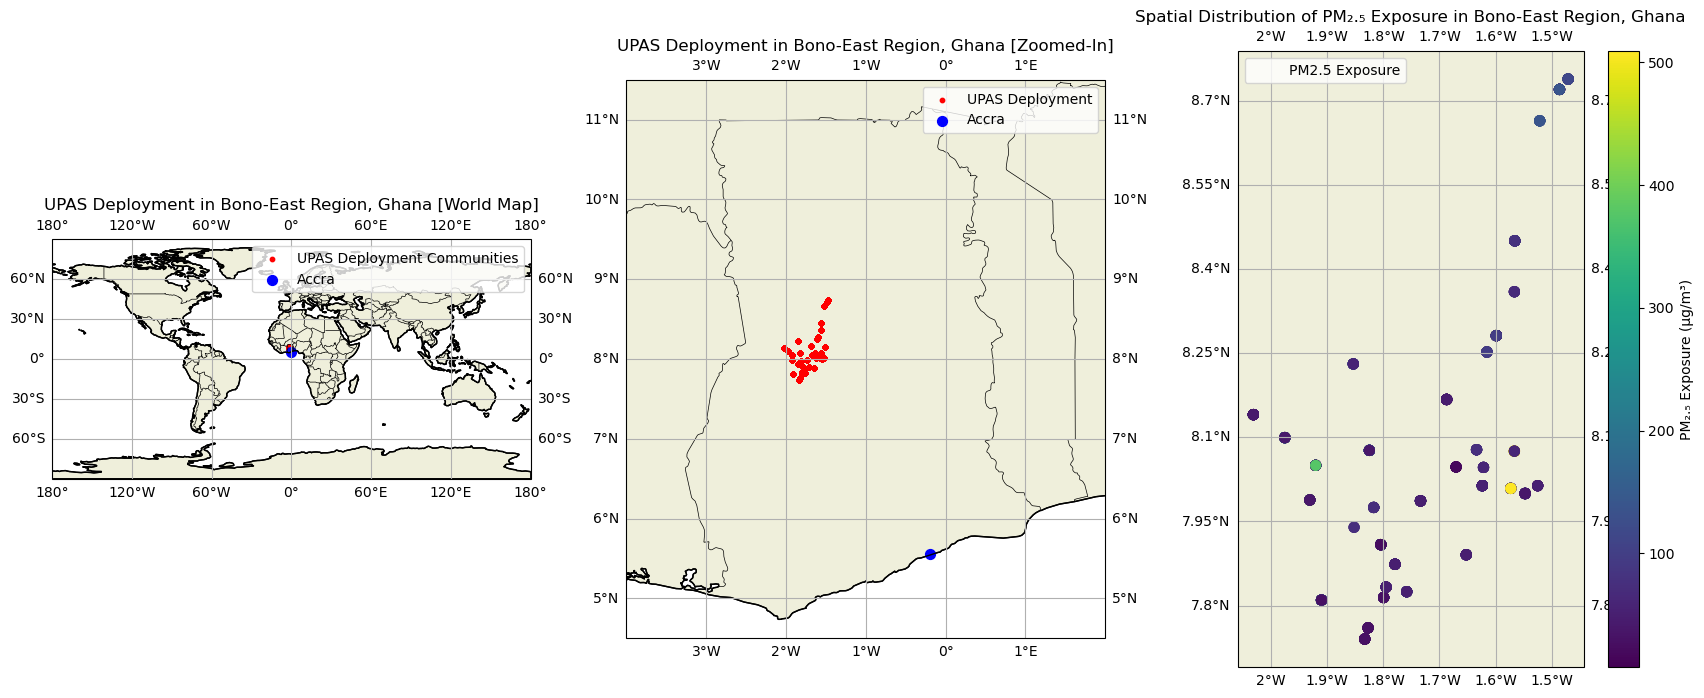

In [7]:
# Load longitude and latitudes
accra_lon = -0.1974
accra_lat = 5.5593
lon = df_rh_temp_compliance['lon']
lat = df_rh_temp_compliance['lat']

# Subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(21, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1 - World map with UPAS deployments
axs[0].set_title("UPAS Deployment in Bono-East Region, Ghana [World Map]")
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
axs[0].add_feature(cfeature.LAND, edgecolor='black')
axs[0].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # shows entire world
axs[0].scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree(), label="UPAS Deployment Communities")
axs[0].scatter(accra_lon, accra_lat, color='blue', s=50, transform=ccrs.PlateCarree(), label="Accra")
axs[0].gridlines(draw_labels=True)
axs[0].legend()

# Plot 2 - Zoomed-in map of Ghana
axs[1].set_title("UPAS Deployment in Bono-East Region, Ghana [Zoomed-In]")
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
axs[1].add_feature(cfeature.LAND, edgecolor='black')  
axs[1].set_extent([-4, 2, 4.5, 11.5], crs=ccrs.PlateCarree())  # zoom into Ghana
axs[1].scatter(lon, lat, color='red', s=10, transform=ccrs.PlateCarree(), label="UPAS Deployment")
axs[1].scatter(accra_lon, accra_lat, color='blue', s=50, transform=ccrs.PlateCarree(), label="Accra")
axs[1].gridlines(draw_labels=True)
axs[1].legend()

# Resample PM2.5 data based on 48-hour deployments and calculate rolling median
resampled_pm25_rh_temp = df_rh_temp_compliance.resample('2D', on='DateTimeUTC')['PM2_5MC'].mean().reset_index()
resampled_pm25_rh_temp['PM2_5MC'] = resampled_pm25_rh_temp['PM2_5MC'].interpolate(method='linear')
resampled_pm25_rh_temp = pd.merge(resampled_pm25_rh_temp, df_rh_temp_compliance[['DateTimeUTC', 'lat', 'lon']], how='left', on='DateTimeUTC')
window_size = 10
resampled_pm25_rh_temp['Rolling_Median'] = resampled_pm25_rh_temp['PM2_5MC'].rolling(window=window_size, center=True).median()

# Extract lat, long, pm2.5 exposure 
lat = resampled_pm25_rh_temp['lat']
lon = resampled_pm25_rh_temp['lon']
pm25 = resampled_pm25_rh_temp['PM2_5MC']

# Plot 3 - PM2.5 exposure spatial distribution 
scatter = axs[2].scatter(lon, lat, c=pm25, cmap='viridis', s=50, transform=ccrs.PlateCarree(), label="PM2.5 Exposure")
axs[2].set_title("Spatial Distribution of PM₂.₅ Exposure in Bono-East Region, Ghana")
axs[2].coastlines()
axs[2].add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
axs[2].add_feature(cfeature.LAND, edgecolor='black')
axs[2].gridlines(draw_labels=True)
cbar = plt.colorbar(scatter, ax=axs[2], orientation='vertical', label="PM₂.₅ Exposure (µg/m³)") #
axs[2].legend()
plt.show()


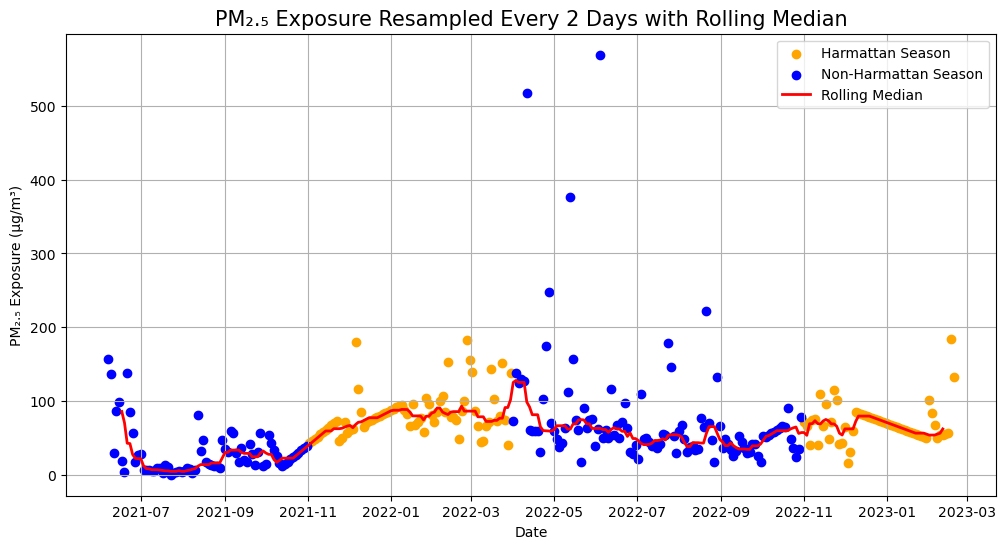

In [8]:
# Plot a time-series of resampled PM2.5 exposure rolling mean for 48-hour deployments

resampled_pm25 = df_compliance.resample('2D', on='DateTimeUTC')['PM2_5MC'].mean().reset_index() # resample the data by 2 days (48-hour deployment) and calculate the mean PM2.5 value per 2-day period

resampled_pm25['PM2_5MC'] = resampled_pm25['PM2_5MC'].interpolate(method='linear') # interpolate where there would be NaN using linear interpolation

# Calculate the rolling median within a specific time window
window_size = 10 # specific time window
resampled_pm25['Rolling_Median'] = resampled_pm25['PM2_5MC'].rolling(window=window_size, center=True).median() # calculate rolling mean

# Classify data points as Harmattan (November to March) or non-Harmattan (April to October) months
resampled_pm25['Month'] = resampled_pm25['DateTimeUTC'].dt.month # extract month from resampled data
harmattan = resampled_pm25[resampled_pm25['Month'].isin([11, 12, 1, 2, 3])] # assign November to March as Harmattan season
non_harmattan = resampled_pm25[resampled_pm25['Month'].isin([4, 5, 6, 7, 8, 9, 10])] # assign April to October as non-Harmattan season

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(harmattan['DateTimeUTC'], harmattan['PM2_5MC'], label='Harmattan Season', color='orange')
plt.scatter(non_harmattan['DateTimeUTC'], non_harmattan['PM2_5MC'], label='Non-Harmattan Season', color='blue')
plt.plot(resampled_pm25['DateTimeUTC'], resampled_pm25['Rolling_Median'], color='red', label='Rolling Median', linewidth=2) # plot rolling weighed median
plt.ylabel("PM₂.₅ Exposure (µg/m³)")
plt.xlabel("Date")
plt.xticks()
plt.yticks()
plt.title("PM₂.₅ Exposure Resampled Every 2 Days with Rolling Median", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

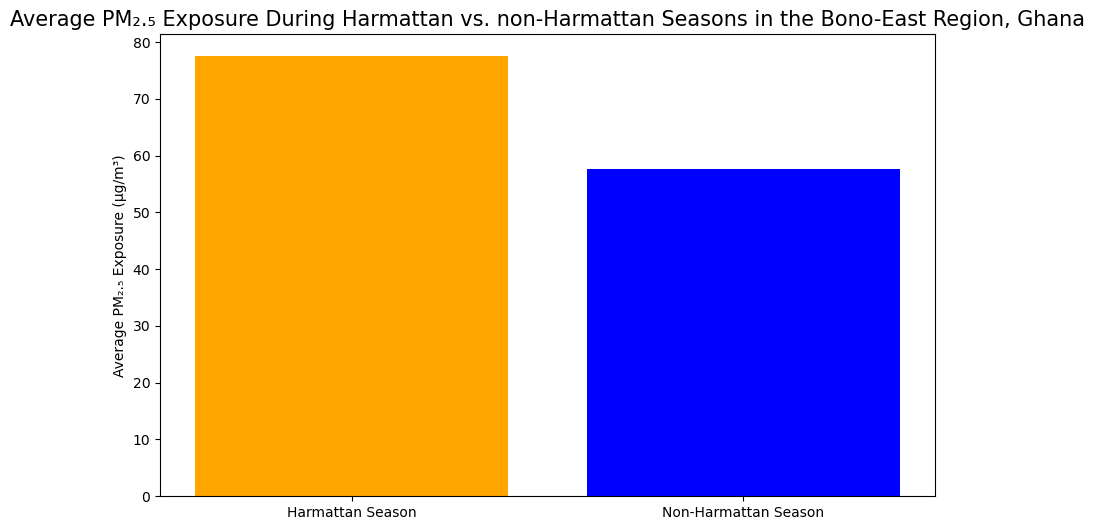

PM2.5 exposure during Harmattan months: 77.49 µg/m³.
PM2.5 exposure during non-Harmattan months: 57.62 µg/m³.


In [9]:
# Determine average PM2.5 exposure during Harmattan vs. non-Harmattan seasons

harmattan_avg_pm25 = harmattan['PM2_5MC'].mean() # calculate the average PM2.5 concentration for Harmattan season
non_harmattan_avg_pm25 = non_harmattan['PM2_5MC'].mean() # calculate the average PM2.5 concentration for non-Harmattan season

# Plot
plt.figure(figsize=(10, 6))
plt.bar(['Harmattan Season', 'Non-Harmattan Season'], [harmattan_avg_pm25, non_harmattan_avg_pm25], color=['orange', 'blue'])
plt.ylabel("Average PM₂.₅ Exposure (µg/m³)")
plt.title("Average PM₂.₅ Exposure During Harmattan vs. non-Harmattan Seasons in the Bono-East Region, Ghana", fontsize = 15)
plt.show()

print("PM2.5 exposure during Harmattan months:", harmattan_avg_pm25.round(2), "µg/m³." )
print("PM2.5 exposure during non-Harmattan months:", non_harmattan_avg_pm25.round(2) , "µg/m³.")
      

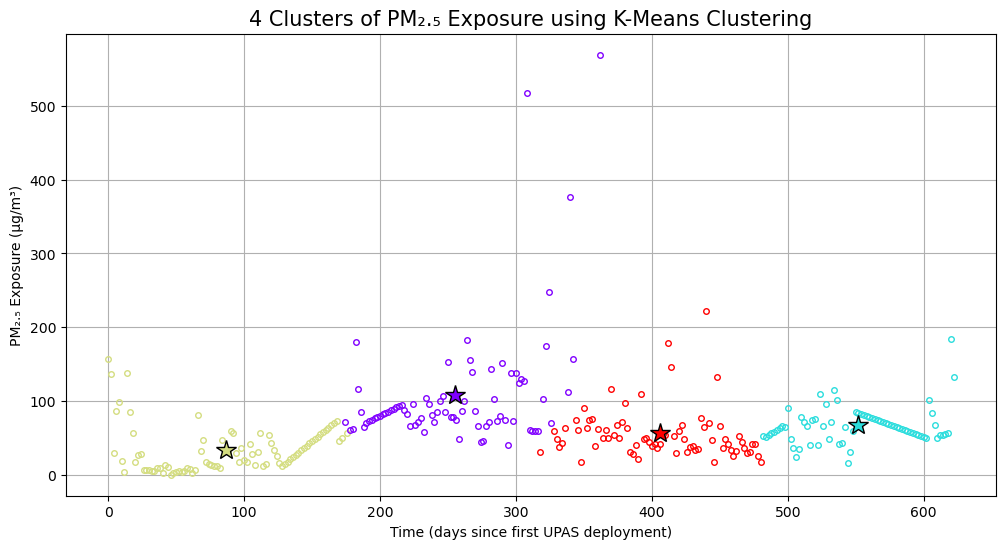

In [12]:
# Determine if PM2.5 exposure differs between Harmattan vs. non-Harmattan season using k-means clustering

resampled_pm25['Time_Numeric'] = (resampled_pm25['DateTimeUTC'] - resampled_pm25['DateTimeUTC'].min()) / np.timedelta64(1, 'D') # convert time to time after deployment
data = resampled_pm25[['Time_Numeric', 'PM2_5MC']].values # use 48-hour deplyment resampled data
data_clean = data[~np.isinf(data).any(axis=1)]  # remove INF values

# K-means clustering with 4 clusters [code modified from lecture 12]
for NUM_CLUSTERS in [4]:
    #--------- KMeans -------------------------
    centroids, _ = kmeans(data_clean, NUM_CLUSTERS, iter=20)
    idx, _ = vq(data_clean, centroids)
    #-----------------------------------------

    COLOR_MAT = cm.rainbow(np.linspace(0, 1, NUM_CLUSTERS)) # set datapoint colours

    plt.figure(figsize=(12, 6))
    plt.title("4 Clusters of PM₂.₅ Exposure using K-Means Clustering", fontsize = 15)

    for ind, val in enumerate(data_clean): # plot clusters
        plt.plot(val[0], val[1], '.', color=COLOR_MAT[idx[ind]], markersize=8, markerfacecolor='none')

    for ind, val in enumerate(centroids): # plot the centroids
        plt.plot(val[0], val[1], '*', color=COLOR_MAT[ind], markersize=15, markeredgecolor='black')

    plt.xlabel("Time (days since first UPAS deployment)")
    plt.ylabel("PM₂.₅ Exposure (µg/m³)")
    plt.xticks()
    plt.yticks()
    plt.grid(True)
    plt.show()


/tmp/ipykernel_7715/3272159369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compliance['DateTimeUTC'] = pd.to_datetime(df_compliance['DateTimeUTC'])


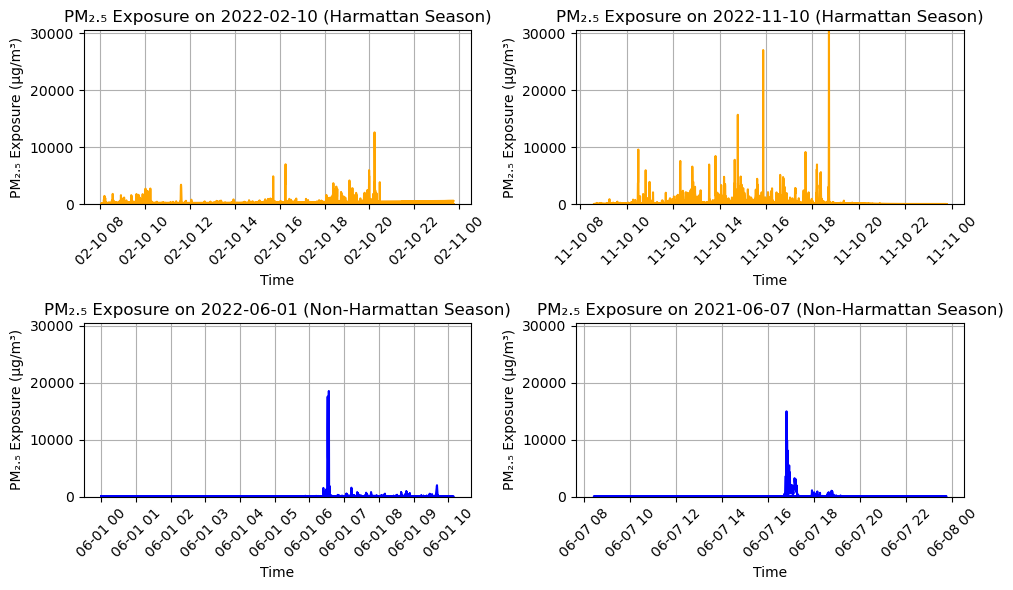

In [29]:
# Plotting PM2.5 exposure for select days during Harattam vs. Non-Harmattan seasons

df_compliance['DateTimeUTC'] = pd.to_datetime(df_compliance['DateTimeUTC'])

# Filter data for specific days
Feb2022_Harmattan = df_compliance[df_compliance['DateTimeUTC'].dt.date == pd.to_datetime('2022-02-10').date()] # Feb 2022 Harmattan
Nov2022_Harmattan = df_compliance[df_compliance['DateTimeUTC'].dt.date == pd.to_datetime('2022-11-10').date()] # Nov 2022 Harmattan
June2022_non_Harmattan = df_compliance[df_compliance['DateTimeUTC'].dt.date == pd.to_datetime('2022-06-01').date()] # June 2022 non-Harmattan
June2021_non_Harmattan = df_compliance[df_compliance['DateTimeUTC'].dt.date == pd.to_datetime('2021-06-07').date()] # June 2021 non-Harmattan

# Datafor plotting
time_Feb2022_Harmattan = Feb2022_Harmattan['DateTimeUTC']
pm25_Feb2022_Harmattan = Feb2022_Harmattan['PM2_5MC']

time_Nov2022_Harmattan = Nov2022_Harmattan['DateTimeUTC']
pm25_Nov2022_Harmattan = Nov2022_Harmattan['PM2_5MC']

time_June2022_Harmattan = June2022_non_Harmattan['DateTimeUTC']
pm25_June2022_Harmattan = June2022_non_Harmattan['PM2_5MC']

time_June2021_Harmattan = June2021_non_Harmattan['DateTimeUTC']
pm25_June2021_Harmattan = June2021_non_Harmattan['PM2_5MC']

# Plot the 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6))  # 2 rows, 2 columns

# Harmattan Season (Feb. 2022)
axs[0,0].plot(time_Feb2022_Harmattan, pm25_Feb2022_Harmattan, color='orange')
axs[0,0].set_title("PM₂.₅ Exposure on 2022-02-10 (Harmattan Season)")
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("PM₂.₅ Exposure (µg/m³)")
axs[0,0].set_ylim(0, 30500)
axs[0,0].tick_params(axis='x', rotation = 45)  
axs[0,0].tick_params(axis='y')  
axs[0,0].grid(True)

# Harmattan Season (Nov. 2022)
axs[0,1].plot(time_Nov2022_Harmattan, pm25_Nov2022_Harmattan, color='orange')
axs[0,1].set_title("PM₂.₅ Exposure on 2022-11-10 (Harmattan Season)")
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("PM₂.₅ Exposure (µg/m³)")
axs[0,1].set_ylim(0, 30500)
axs[0,1].tick_params(axis='x', rotation = 45)  
axs[0,1].tick_params(axis='y')
axs[0,1].grid(True)

# Non-Harmattan Season (June 2022)
axs[1,0].plot(time_June2022_Harmattan, pm25_June2022_Harmattan, color='blue')
axs[1,0].set_title("PM₂.₅ Exposure on 2022-06-01 (Non-Harmattan Season)")
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("PM₂.₅ Exposure (µg/m³)")
axs[1,0].set_ylim(0, 30500)
axs[1,0].tick_params(axis='x', rotation = 45)  
axs[1,0].tick_params(axis='y')
axs[1,0].grid(True)

# Non-Harmattan Season (June 2021)
axs[1,1].plot(time_June2021_Harmattan, pm25_June2021_Harmattan, color='blue')
axs[1,1].set_title("PM₂.₅ Exposure on 2021-06-07 (Non-Harmattan Season)")
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("PM₂.₅ Exposure (µg/m³)")
axs[1,1].set_ylim(0, 30500)
axs[1,1].tick_params(axis='x', rotation = 45)  
axs[1,1].tick_params(axis='y')
axs[1,1].grid(True)

plt.tight_layout()
plt.show()


P-value (temp vs. PM₂.₅): 3.6466212422473775e-248
P-value (RH vs. PM₂.₅): 9.923197952419508e-175
P-value (wearing compliance vs. PM₂.₅): 1.7947384365512188e-20


/srv/conda/envs/eofs-cookbook-dev/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


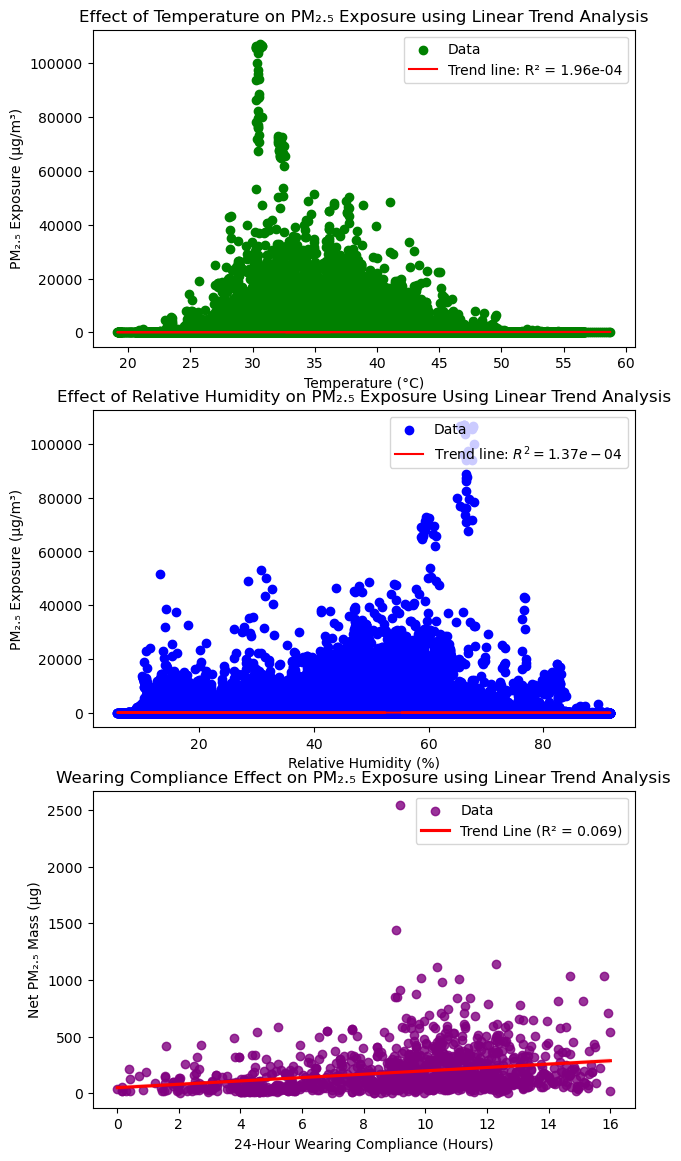

In [46]:
# Plot the relationship between temp, RH, and wearing compliance and PM2.5 using linear trend analysis

# Extract data
temperature = df_rh_temp_compliance['AtmoT']  
pm25 = df_rh_temp_compliance['PM2_5MC']  
rh = df_rh_temp_compliance['AtmoRH'] 

# Calculate linear regression for temp vs. PM2.5
slope_temp, intercept_temp, r_value_temp, p_value_temp, std_err_temp = stats.linregress(temperature, pm25)
r_squared = r_value_temp ** 2 # calcualte R^2 value
r_squared_scientific = "{:.2e}".format(r_squared) # write R^2 in scientific notation

# Calculate linear regression for relative humidity vs. PM2.5
slope_rh, intercept_rh, r_value_rh, p_value_rh, std_err_rh = stats.linregress(rh, pm25)
r_squared_rh = r_value_rh ** 2 # calculate R^2 value
r_squared_rh_scientific = "{:.2e}".format(r_squared_rh) # R^2 to scientific notation

# Plot the relationship between wearing compliance and PM2.5 using linear trend analysis
# merge dataset for wearing compliance and PM2.5 mass (in gcratio) and align values based on filter ID
merged_df = pd.merge(df_summarized_compliance, gcratio, on='filter_id', how='inner') # original dataset (df_compliance) is too large to load here

# further filter dataset
columns_to_keep_wc = ['filter_id', 'compliance_hours_daytime_24hr', 'netmass_ug'] # only keep these columns
compliance_pm25_merged = merged_df[columns_to_keep_wc]
compliance_pm25_merged = compliance_pm25_merged.dropna() # drop NaN values

# Calculate linear regression for wearing compliance and PM2.5
slope_compliance, intercept_compliance, r_value_compliance, p_value_compliance, std_err_compliance = stats.linregress(compliance_pm25_merged['compliance_hours_daytime_24hr'], compliance_pm25_merged['netmass_ug'])
r_squared_compliance = r_value_compliance ** 2

fig, axs = plt.subplots(3, 1, figsize=(7, 14))  # 3 rows, 1 columns 

# Create scatter plot for temperature vs PM2.5
axs[0].scatter(temperature, pm25, label='Data', color='green')
axs[0].plot(temperature, slope_temp * temperature + intercept_temp, color='red', label=f"Trend line: R² = {r_squared_scientific}")
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('PM₂.₅ Exposure (µg/m³)')
axs[0].set_title("Effect of Temperature on PM₂.₅ Exposure using Linear Trend Analysis")
axs[0].legend()

print("P-value (temp vs. PM₂.₅):", p_value_temp)

# Create scatter plot for rh vs PM2.5
axs[1].scatter(rh, pm25, label='Data', color='blue')
axs[1].plot(rh, slope_rh * rh + intercept_rh, color='red', label=f'Trend line: $R^2 = {r_squared_rh_scientific}$')
axs[1].set_xlabel('Relative Humidity (%)')
axs[1].set_ylabel('PM₂.₅ Exposure (µg/m³)')
axs[1].set_title("Effect of Relative Humidity on PM₂.₅ Exposure Using Linear Trend Analysis")
axs[1].legend(loc='upper right')

print("P-value (RH vs. PM₂.₅):", p_value_rh)

# Create scatterplot for wearing compliance and PM2.5 exposure
sns.regplot(x='compliance_hours_daytime_24hr', y='netmass_ug', data=compliance_pm25_merged, scatter_kws={'color': 'purple'}, line_kws={'color': 'red'}, ax=axs[2])
axs[2].set_xlabel('24-Hour Wearing Compliance (Hours)')
axs[2].set_ylabel('Net PM₂.₅ Mass (µg)')
axs[2].set_title("Wearing Compliance Effect on PM₂.₅ Exposure using Linear Trend Analysis")
axs[2].legend(['Data', f'Trend Line (R² = {r_squared_compliance.round(3)})'], loc='upper right')

print("P-value (wearing compliance vs. PM₂.₅):", p_value_compliance)
plt.show()

## Discussion & Conclusions

Household air pollution is the leading cause of death in developing nations. This project found that there is an increase in PM₂.₅ exposure during the Harmattan months. On average, there is ~77.49 µg/m³ of PM₂.₅ exposure during the Harmattan season (November to March) comapred to ~57.62 µg/m³ of PM₂.₅ expsoure during the non-Harmattan season (April to October). The k-means cluster analysis classifies the datapoints between Harmattan and non-Harmattan months and further supports the increased PM₂.₅ exposure during the Harmattan season and decreased PM₂.₅ exposure during the non-Harmattan season.

Additionally, participants are experience greater variability in daily PM₂.₅ exposure during the Harmattan season experience compared to the non-Harmattan season. This is seen on Feburary 10, 2022 and November 10, 2022 (Harmattan season) compared to June 1, 2021 and June 1, 2022 (non-Harmattan season). During the non-Harmattan season, peaks in the PM₂.₅ exposure are likey due to biomass burning from cooking-related activities. 

There is no correlation between relative humidity, temperature and wearing compliance on PM₂.₅ exposure. Relative humidity and temperature likely do not significantly impact PM₂.₅ exposure because they can be affected by human-error. For instance, body heat and respiration can impact ambient relative humidity and temperature readings. 


Next steps include to determine how much PM₂.₅ conrtributes to metal exposure from Saharan dust and biomass burning using analytical geochemistry methods (e.g., spectroscopy and x-ray flourescence). 


#### 